In [2]:
import pandas as pd
import numpy as np

In [3]:
import ast
import nltk
from nltk.stem.porter import PorterStemmer

In [4]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
!pip install scikit-surprise

In [6]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
import pickle

In [7]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [8]:
print("Movies dataset - ",movies.shape)
print("Movies dataset - ",credits.shape)

Movies dataset -  (4803, 20)
Movies dataset -  (4803, 4)


In [9]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [10]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [11]:
movies = pd.merge(movies, credits, on='title')

In [12]:
# Now we are sorting Tags that might be usefull while reccommending ''
# genres , id ( To fetch posters { When we represent this project}) ,keywords
# title (Not original title because 'title is always in en')
# Overview , cast , crew ( Only director )

# Rest of the data will not be used in our movies dataframe

In [13]:
# Preprocess movie data
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies = movies.dropna()
# Finding Missing data

In [14]:
# Drop the Row with missing data
movies.dropna(inplace=True)

In [15]:
# Check for duplicate rows
movies.duplicated().sum()

0

In [16]:
print(movies['genres'].unique())

['[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'
 '[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]'
 '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 80, "name": "Crime"}]'
 ...
 '[{"id": 53, "name": "Thriller"}, {"id": 27, "name": "Horror"}, {"id": 35, "name": "Comedy"}]'
 '[{"id": 10769, "name": "Foreign"}, {"id": 53, "name": "Thriller"}]'
 '[{"id": 35, "name": "Comedy"}, {"id": 18, "name": "Drama"}, {"id": 10749, "name": "Romance"}, {"id": 10770, "name": "TV Movie"}]']


In [17]:
# Converting the list from genres more elegent
# Obj is string that consists of list and dictonary type of python objects
def convert(obj):
    list_=[];
    # Now Obj is converted to List from string (Automatically , because it was its python object equivalent.)
    for i in ast.literal_eval(obj):
      # Also we only stored names from this object , this is what we want .
        list_.append(i['name'])
    return list_


In [18]:
def Find_Top_4(obj):# _Obj_ is string ( same as before )
    list_=[];
    iterator = 0
    for i in ast.literal_eval(obj):# Now _Obj_ is converted to List from string
        if iterator != 4:# Iterate only to find top 4
            list_.append(i['name'])# Only information about names is required
            iterator+=1
        else :
            break
    return list_

In [19]:
# output List of genres and keywords in list format
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)

In [20]:
def Fetch_Director(obj):
    list_ = []
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            list_.append(i['name'])
            break
    return list_

In [21]:
movies['crew'] = movies['crew'].apply(Fetch_Director)

In [22]:
movies['cast'] = movies['cast'].apply(Find_Top_4)

In [23]:
# movies.head()
movies['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [24]:
def list_to_string(lst):
    if isinstance(lst, list):
        return ' '.join(lst)# Join list items into a single string
    return str(lst)# Convert non-list items to string

In [25]:
# Strip whitespace from all column names
movies.columns = movies.columns.str.strip()
movies['genres'] = movies['genres'].apply(list_to_string)
movies['keywords'] = movies['keywords'].apply(list_to_string)
movies['crew'] = movies['crew'].apply(list_to_string)
movies['cast'] = movies['cast'].apply(list_to_string)

In [26]:
movies['genres'] = movies['genres'].str.lower()
movies['keywords'] = movies['keywords'].str.lower()
movies['crew'] = movies['crew'].str.lower()
movies['cast'] = movies['cast'].str.lower()

In [27]:
movies['tags'] = ( movies['overview'] + ' ' +
                  movies['genres'] + ' ' +
                  movies['keywords'] + ' ' +
                  movies['crew'] + ' ' +
                  movies['cast']
                 )

In [28]:
# Now we create a new Dataframe which contains all the entries that we will require
Final_df = movies[['movie_id','title','tags']]
Final_df['tags'][442]

"An antiterrorism agent goes under the knife to acquire the likeness of a terrorist and gather details about a bombing plot. When the terrorist escapes custody, he undergoes surgery to look like the agent so he can get close to the agent's family. action crime science fiction thriller undercover mexican standoff biological weapon face transplant rage and hate fistfight hostility revenge deception tragedy shootout hospital boat chase los angeles explosion extreme violence fbi agent prison escape criminal gang flashback golden gun arch villain bullet ballet john woo john travolta nicolas cage joan allen alessandro nivola"

In [29]:
Final_df.loc[:, 'tags'] = Final_df['tags'].apply(lambda x: x.lower())

In [30]:
# Bag of words
cv = CountVectorizer(max_features=10000, stop_words='english')

In [31]:
vectors = cv.fit_transform(Final_df['tags']).toarray()

In [32]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [33]:
print(vectors.shape)
cv.get_feature_names_out()
# It is tuple

(4806, 10000)


array(['000', '007', '10', ..., 'zucker', 'zwick', 'åkerman'],
      dtype=object)

In [34]:
# Applying Stemming , finds out root word of common words { action , actions etc}
# Installing nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [35]:
# Helper Function
def stemming(text_to_be_stemmed):
    list_ = []
    for i in text_to_be_stemmed.split():
        list_.append(ps.stem(i))
    return " ".join(list_)

In [36]:
Final_df.loc[:,'tags'] = Final_df['tags'].apply(stemming)

In [37]:
Final_df['tags'][0]

'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi scienc fiction cultur clash futur space war space coloni societi space travel futurist romanc space alien tribe alien planet cgi marin soldier battl love affair anti war power relat mind and soul 3d jame cameron sam worthington zoe saldana sigourney weaver stephen lang'

In [38]:
# We are done with vectorization
# Next step is to calculate cosine distance { Not euclidian distance }
# using cosine_similarity() function of sklearn
#  ( More Distance ) =  ( More Dis_Similiarity )
# Now the similarity matrix we have here will always have its diagonal = '0' , because every movie must be 100 % similiar to itself .
# Here '0' is index of movie
# sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6]
# A list will be printed containing top 5 similiar movies to our selection

In [39]:
similarity = cosine_similarity(vectors)

In [40]:
Final_df.loc[:, 'title'] = Final_df['title'].apply(lambda x: x.lower())

In [41]:
def recommend(movie):
    movie = movie.lower()
    if movie not in Final_df['title'].values:
        print(f"Movie '{movie}' not found in the database.")
        return
    # Here index[0] means when we search for title if there are multiple matches , it will pick up the first one .
    # movie_index = Final_df[Final_df['title'] == movie] make sure it finds title in dataframe .
    
    movie_index = Final_df[Final_df['title'] == movie].index[0]
    distances = similarity[movie_index]

    # print(f"Distances for {movie}: {distances}")  # Debugging line

    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    
    print("Recommended Movies: ")
    for i in movies_list:
        print(Final_df.iloc[i[0]].title)


In [42]:
# Example usage
recommend("Batman")

Recommended Movies: 
batman
batman & robin
batman returns
batman begins
the dark knight rises


In [144]:
# Sample user data (Actual data not available)
user_data = {
    'user1': {'movie_id': [100, 33, 14], 'rating': [5, 4, 3]},  # Movie IDs and ratings for user1
    'user2': {'movie_id': [200, 44, 15], 'rating': [2, 5, 3]}   # Movie IDs and ratings for user2
}

In [148]:
# Create a user-item interaction matrix
ratings_data = []
for user, data in user_data.items():
    for i in range(len(data['movie_id'])):
        ratings_data.append([user, data['movie_id'][i], data['rating'][i]])

In [194]:
ratings_df = pd.DataFrame(ratings_data, columns=['user', 'movie_id', 'rating'])

# Define the reader for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the data into Surprise
data = Dataset.load_from_df(ratings_df[['user', 'movie_id', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=.25)

# Train a KNNBasic collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': True}  # Use cosine similarity and user-based filtering
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [196]:
user_id = 'user1'
movie_id = 442  # Movie ID to predict rating for
prediction = algo.predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} and movie {movie_id}: {prediction.est}")

Predicted rating for user user1 and movie 442: 3.0


In [198]:
def get_cf_recommendations(user_id, search_movie):
    # Filter to ensure the search movie exists in the data
    if search_movie not in Final_df['title'].values:
        print(f"Movie '{search_movie}' not found in the database.")
        return []
    
    # Calculate similarity for the searched movie
    search_movie_id = Final_df[Final_df['title'] == search_movie].iloc[0]['movie_id']
    search_movie_vector = vectors[Final_df[Final_df['movie_id'] == search_movie_id].index[0]]
    similarities = cosine_similarity([search_movie_vector], vectors).flatten()
    
    # Rank movies by similarity, excluding the search movie itself
    similar_indices = similarities.argsort()[-10:][::-1]  # Top 10 recommendations
    recommendations = Final_df.iloc[similar_indices]
    recommendations = recommendations[recommendations['title'] != search_movie]
    
    return recommendations['title'].tolist()


In [200]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [202]:
def plot_cf_recommendations(user_id, recommendations, search_movie):
    # Get the movie IDs for the recommendations
    recommended_movie_ids = Final_df[Final_df['title'].isin(recommendations)]['movie_id'].tolist()

    # Get the movie IDs for the user's rated movies
    rated_movie_ids = user_data[user_id]['movie_id']

    # Get the movie ID for the searched movie
    if search_movie in Final_df['title'].values:
        search_movie_id = Final_df[Final_df['title'] == search_movie].iloc[0]['movie_id']
    else:
        print(f"Movie '{search_movie}' not found in the database.")
        return

    # Create a list of all movie IDs to be plotted
    all_movie_ids = rated_movie_ids + recommended_movie_ids + [search_movie_id]

    # Get the movie titles and their corresponding vectors
    movie_titles = Final_df[Final_df['movie_id'].isin(all_movie_ids)]['title'].tolist()
    movie_vectors = vectors[[Final_df[Final_df['title'] == title].index[0] for title in movie_titles]]

    # Reduce the dimensionality of the vectors to 3 using PCA (for visualization)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    movie_vectors_3d = pca.fit_transform(movie_vectors)

    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the user's rated movies in blue
    ax.scatter(movie_vectors_3d[:len(rated_movie_ids), 0],
               movie_vectors_3d[:len(rated_movie_ids), 1],
               movie_vectors_3d[:len(rated_movie_ids), 2],
               c='blue', label='Rated Movies')

    # Plot the recommended movies in red
    ax.scatter(movie_vectors_3d[len(rated_movie_ids):len(rated_movie_ids)+len(recommended_movie_ids), 0],
               movie_vectors_3d[len(rated_movie_ids):len(rated_movie_ids)+len(recommended_movie_ids), 1],
               movie_vectors_3d[len(rated_movie_ids):len(rated_movie_ids)+len(recommended_movie_ids), 2],
               c='red', label='Recommended Movies')

    # Plot the searched movie in green
    ax.scatter(movie_vectors_3d[-1, 0], movie_vectors_3d[-1, 1], movie_vectors_3d[-1, 2],
               c='green', label='Searched Movie', s=100, edgecolors='k')

    # Add labels to the points (optional)
    for i, title in enumerate(movie_titles):
        ax.text(movie_vectors_3d[i, 0], movie_vectors_3d[i, 1], movie_vectors_3d[i, 2], title)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title(f'Collaborative Filtering Recommendations for {user_id}')
    plt.show()


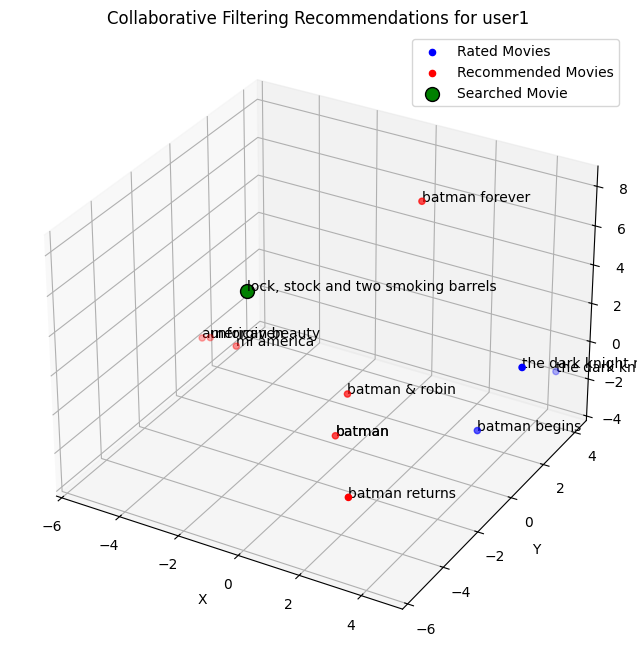

Collaborative Filtering Recommendations for user1: ['batman & robin', 'batman returns', 'batman begins', 'the dark knight rises', 'the dark knight', 'batman forever', 'mi america']


In [236]:
# Get recommendations for user1
# Example usage:
cf_recommendations_user1 = get_cf_recommendations('user1','batman')
plot_cf_recommendations('user1', cf_recommendations_user1,'batman')
print(f"Collaborative Filtering Recommendations for user1: {cf_recommendations_user1}")

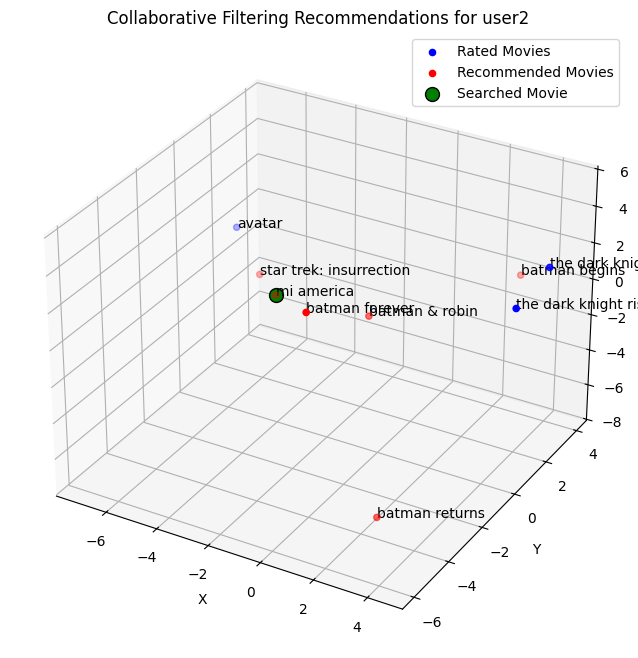

Collaborative Filtering Recommendations for user2: ['aliens', 'moonraker', 'alien', 'alien³', 'mission to mars', 'silent running', 'lockout', 'lifeforce', 'spaceballs']


In [238]:
# Get recommendations for user1
# Example usage:
cf_recommendations_user2 = get_cf_recommendations('user2','avatar')
plot_cf_recommendations('user2', cf_recommendations_user1,'avatar')
print(f"Collaborative Filtering Recommendations for user2: {cf_recommendations_user2}")